# **SPAM FILTER**
*Authors: [Charalampos Spanias](https://github.com/CSpanias), [Artjoms Dobiss](https://github.com/adobiss)*

## This project was developed as an assignment for
  * [Skills Bootcamp in Artificial Intelligence](https://instituteofcoding.org/skillsbootcamps/course/skills-bootcamp-in-artificial-intelligence/).

## This code is mainly based on: 
  * [Email Spam Detection Using Python & Machine Learning](https://www.youtube.com/watch?v=cNLPt02RwF0&list=WL&index=4&t=12s)
	

## It was modified based on:
  * [Spam or Ham tutorial](https://github.com/tejank10/Spam-or-Ham/blob/master/spam_ham.ipynb)

  * [SVM Classifier tutorial](https://www.kaggle.com/prashant111/svm-classifier-tutorial/notebook)

  * [Sololearn (Machine Learning path)](https://www.sololearn.com/learning/1094)

  * [Machine Learning for Absolute Beginners book](https://www.amazon.co.uk/Machine-Learning-Absolute-Beginners-Introduction-ebook/dp/B08RWBSKQB)

Import the required libraries:
  1. ***pandas*** for importing dataset(*)
  2. ***matplotlib*** & ***seaborn*** for visualisation
  3. ***string*** & ***nltk*** for object manipulation
  4. ***sklearn*** for machine learning
  5. ***wordcloud*** for wordcloud visualization

In [99]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import numpy as np

from nltk.corpus import stopwords
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB, CategoricalNB
from sklearn.svm import SVC
from wordcloud import WordCloud

In [3]:
# Load data
from google.colab import files
uploaded = files.upload()

Saving emails.csv to emails.csv


In [18]:
# read the CSV file
df = pd.read_csv('emails.csv')

# print the first 5 rows of data
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


# **Data Cleaning Process**

  * Duplicates
  * Missing values

In [19]:
# print the number of rows and columns
df.shape

(5728, 2)

In [20]:
# check for duplicates
print(df.duplicated().sum())
# remove duplicates
df.drop_duplicates(inplace=True)

33


In [21]:
# check for missing values
df.isna().sum()

text    0
spam    0
dtype: int64

# **Object Manipulation Process**

  1. Remove punctuation from text
  2. Remove stopwords from text
  3. Split text in individual words

In [22]:
# download the stopwords package
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Define a function that:
  1. Removes punctuation symbols and stopwords from a text
  2. Splits the text into individual words
  3. Stores the individual words in a list

In [23]:
def process_text(text):
	"""
		Returns a list of strings (individual words) of a text (paragraph) excluding
		punctuation, stopwords.

			Parameters
			----------
				text: An object (string) variable.

			Returns
			-------
				clean_words: A list of objects (string).
		"""
	# create an empty list to later store the rows (emails) without punctuation
	no_punctuation = []
	# create an empty list to later store the words of each row (email)
	clean_words = []
	# for every row (email) in the text column
	for char in text:
		# remove every punctuation symbol
		if char not in string.punctuation:
			# append the free-of-punctuation row in the list "no_punctuation"
			no_punctuation.append(char)
	# insert an empty space between words
	no_punctuation = ''.join(no_punctuation)

	# for every row (email without punctuation symbols) in
	# the "no_punctuation" list split the text into words
	for word in no_punctuation.split():
		# convert every word in lowercase
		word = word.lower()
		# if this word is not a stopword
		if word not in stopwords.words('english'):
			# append the free-of-stopwords words in the list "clean_words"
			clean_words.append(word)
	# give back the list "clean_words"
	return clean_words

Apply the function "process_text" to the column "text" so we end up with a column of individual words and print the first 5 rows.

In [24]:
df['text'].head().apply(process_text)

0    [subject, naturally, irresistible, corporate, ...
1    [subject, stock, trading, gunslinger, fanny, m...
2    [subject, unbelievable, new, homes, made, easy...
3    [subject, 4, color, printing, special, request...
4    [subject, money, get, software, cds, software,...
Name: text, dtype: object

***CountVectorizer*** transforms a given text into a vector on the basis of 
the frequency (count) of each word that occurs in the entire text. 

More info on how it works [here](https://www.geeksforgeeks.org/using-countvectorizer-to-extracting-features-from-text/).

In [25]:
# convert a collection of text to a matrix of tokens (*bow = bog of words)
messages_bow = CountVectorizer(analyzer=process_text).fit_transform(df['text'])

Create a wordcloud visualisation for the spam words.

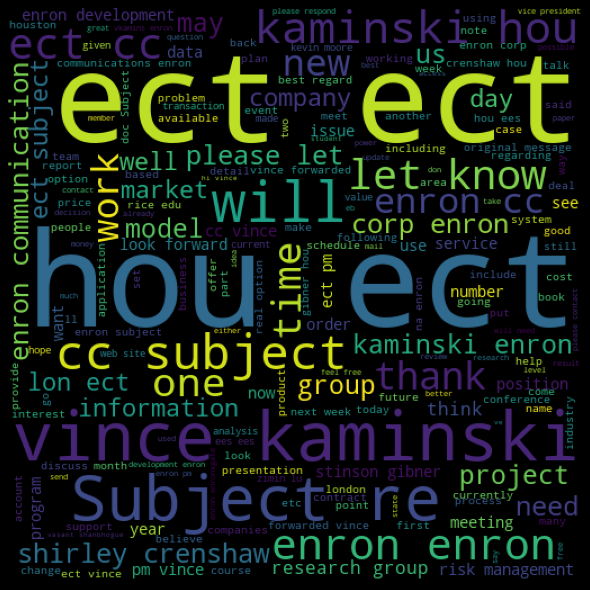

In [26]:
spam_wordcloud = WordCloud(width=512, height=512).generate(' '.join(df['text']))
plt.figure(figsize=(10, 8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# **Model Training Process**

In [105]:
# assign X and y variables
X = messages_bow
y = df['spam']

# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    random_state=1)

In [28]:
# get the shape of X (rows, columns)
X.shape

(5695, 37228)

**Multinomial Naive-Bayes**

Why Naive-Bayes?
  1. 
  2.

Which Naive-Bayes?
  1. **Gaussian** 
    * Assumes data normality! Is our data normal?
  2. **Multinomial** 
    * Assumes data is multinomially distributed.
    * Primarily used for document classification tasks based on ***word frequency***! Relevant?
  3. **Bernoulli**
    * Similar to Multinomial, but the features are ***independent Boolean variables***.
    * For example, if a word is present is not! More suitable for our task?
  4. **Complemenent** 
    * An adaptation of the multinomial naive Bayes algorithm that is particularly suited for ***imbalanced data sets***!
  5. **Categorical/Gaussian**
    * Eror during training!

In [106]:
# select the model(s)
model_mnb = MultinomialNB()
model_ber = BernoulliNB()
model_com = ComplementNB()

# train the model
model_mnb.fit(X_train, y_train)
model_ber.fit(X_train, y_train)
model_com.fit(X_train, y_train)

ComplementNB()

**Support Vector Machine**

Kernel: RBF

In [114]:
# select the model(s)
model_svm = SVC()
model_svm_c10 = SVC(C=10)
model_svm_c100 = SVC(C=100)
model_svm_c1000 = SVC(C=1000)

# train the model
model_svm.fit(X_train, y_train)
model_svm_c10.fit(X_train, y_train)
model_svm_c100.fit(X_train, y_train)
model_svm_c1000.fit(X_train, y_train)

SVC(C=1000)

# **Model Evaluation**

Calculate accuracy scores with different variations of Naive-Bayes algorithm.

In [107]:
# check the prediction using Multinomial NB
print("Accuracy Score using Multinomial Naive-Bayes:\n")

# calculate accuracy score on training set
y_pred_train_mnb = model_mnb.predict(X_train)
# print accuracy score on training set
print('Training Set: ', round(accuracy_score(y_train, y_pred_train_mnb), 4))
# calculate accuracy score on test set
y_pred_test_mnb = model_mnb.predict(X_test)
print('Testing set: ', round(accuracy_score(y_test, y_pred_test_mnb), 4))

# check the prediction using Bernoulli NB
print("\nAccuracy Score using Bernoulli Naive-Bayes:\n")
# calculate accuracy score on training set
y_pred_train_ber = model_ber.predict(X_train)
# print accuracy score on training set
print('Training Set: ', round(accuracy_score(y_train, y_pred_train_ber), 4))
# calculate accuracy score on test set
y_pred_test_ber = model_ber.predict(X_test)
print('Testing set: ', round(accuracy_score(y_test, y_pred_test_ber), 4))


# check the prediction using Complement NB
print("\nAccuracy Score using Complement Naive-Bayes:\n")
# calculate accuracy score on training set
y_pred_train_com = model_com.predict(X_train)
# print accuracy score on training set
print('Training Set: ', round(accuracy_score(y_train, y_pred_train_com), 4))
# calculate accuracy score on test set
y_pred_test_com = model_com.predict(X_test)
print('Testing set: ', round(accuracy_score(y_test, y_pred_test_com), 4))

Accuracy Score using Multinomial Naive-Bayes:

Training Set:  0.9971
Testing set:  0.9912

Accuracy Score using Bernoulli Naive-Bayes:

Training Set:  0.9917
Testing set:  0.9798

Accuracy Score using Complement Naive-Bayes:

Training Set:  0.9971
Testing set:  0.9912


In [115]:
# check the prediction using Support Vector Machine with default settings
print("Accuracy Score using Support Vector Machine (kernel = rbf, C=0.1):\n")
# calculate accuracy score on training set
y_pred_train_svm = model_svm.predict(X_train)
# print accuracy score on training set
print('Training Set: ', round(accuracy_score(y_train, y_pred_train_svm), 4))
# calculate accuracy score on test set
y_pred_test_svm = model_svm.predict(X_test)
print('Testing set: ', round(accuracy_score(y_test, y_pred_test_svm), 4))

# check the prediction using Support Vector Machine with modified settings
print("\nAccuracy Score using Support Vector Machine (kernel = rbf, C=10):\n")
# calculate accuracy score on training set
y_pred_train_svm_c10 = model_svm_c10.predict(X_train)
# print accuracy score on training set
print('Training Set: ', round(accuracy_score(y_train, y_pred_train_svm_c10), 4))
# calculate accuracy score on test set
y_pred_test_svm_c10 = model_svm_c10.predict(X_test)
print('Testing set: ', round(accuracy_score(y_test, y_pred_test_svm_c10), 4))

# check the prediction using Support Vector Machine with modified settings
print("\nAccuracy Score using Support Vector Machine (kernel = rbf, C=100):\n")
# calculate accuracy score on training set
y_pred_train_svm_c100 = model_svm_c100.predict(X_train)
# print accuracy score on training set
print('Training Set: ', round(accuracy_score(y_train, y_pred_train_svm_c100), 4))
# calculate accuracy score on test set
y_pred_test_svm_c100 = model_svm_c100.predict(X_test)
print('Testing set: ', round(accuracy_score(y_test, y_pred_test_svm_c100), 4))

# check the prediction using Support Vector Machine with modified settings
print("\nAccuracy Score using Support Vector Machine (kernel = rbf, C=1000):\n")
# calculate accuracy score on training set
y_pred_train_svm_c1000 = model_svm_c1000.predict(X_train)
# print accuracy score on training set
print('Training Set: ', round(accuracy_score(y_train, y_pred_train_svm_c1000), 4))
# calculate accuracy score on test set
y_pred_test_svm_c1000 = model_svm_c1000.predict(X_test)
print('Testing set: ', round(accuracy_score(y_test, y_pred_test_svm_c1000), 4))

Accuracy Score using Support Vector Machine (kernel = rbf, C=0.1):

Training Set:  0.9868
Testing set:  0.971

Accuracy Score using Support Vector Machine (kernel = rbf, C=10):

Training Set:  0.9996
Testing set:  0.986

Accuracy Score using Support Vector Machine (kernel = rbf, C=100):

Training Set:  1.0
Testing set:  0.9868
Accuracy Score using Support Vector Machine (kernel = rbf, C=1000):

Training Set:  1.0
Testing set:  0.9868


**The model accuracy with using MNB is 0.9971**. But, we cannot say that our model is very good based on the above accuracy. We must compare it with the **null accuracy** which is the accuracy that could be achieved by always predicting the
most frequent class.

In [62]:
# check class distribution in test set
print(y_test.value_counts())
# check null accuracy score
null_accuracy = (866/(866+273))
print('Null accuracy score: {0:0.4f}'. format(null_accuracy))

0    866
1    273
Name: spam, dtype: int64
Null accuracy score: 0.7603


We can see that our **model accuracy score is 0.9830** but **null accuracy score is 0.7603**. So, we can conclude that our MNB classifier is doing a very good job in predicting the class labels.

In [46]:
# print the classification report on the testing set with MNB
print("\n\t\t\tCLASSIFICATION REPORT\n\n",
      classification_report(y_test, y_pred_test_mnb))

# print the confusion matrix of the testing set with MNB
cm = confusion_matrix(y_test, y_pred_test_mnb)
print("\nCONFUSION MATRIX\n", cm)


			CLASSIFICATION REPORT

               precision    recall  f1-score   support

           0       1.00      0.99      0.99       866
           1       0.97      0.99      0.98       273

    accuracy                           0.99      1139
   macro avg       0.98      0.99      0.99      1139
weighted avg       0.99      0.99      0.99      1139


CONFUSION MATRIX
 [[858   8]
 [  2 271]]


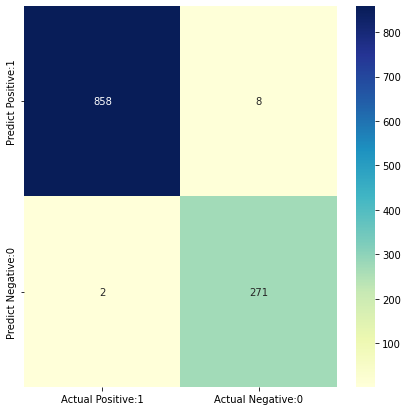

In [54]:
# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1',
                                           'Actual Negative:0'],
                        index=['Predict Positive:1', 'Predict Negative:0'])
fig, ax = plt.subplots(figsize=(7,7))  
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

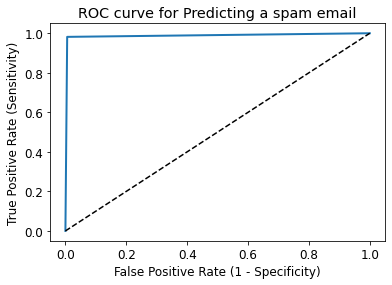

ROC AUC : 0.9880
Cross validated ROC AUC : 0.9972


In [63]:
# plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_svm)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a spam email')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

# compute ROC AUC
ROC_AUC = roc_auc_score(y_test, y_pred_test_svm)
print('ROC AUC : {:.4f}'.format(ROC_AUC))

# calculate cross-validated ROC AUC
Cross_validated_ROC_AUC = cross_val_score(model_svm, X_train, y_train, cv=10,
                                          scoring='roc_auc').mean()
print('Cross validated ROC AUC : {:.4f}'.format(Cross_validated_ROC_AUC))

# **K-Fold Cross-Validation**

**K-fold cross-validation** is a very useful technique to evaluate model 
performance. Instead of doing a single training-test split, we split our dataset multiple times.

The reasons behind K-Fold are:
  1. A certain split selected randomly at the start (*random_state=10*) may not be optimal. 
  2. The test set generated from that split is never used to evaluate the model.

But, ***it fails here because we have a imbalanced dataset***. 
So, in the case of imbalanced dataset, I will use another technique to 
evaluate model performance. It is called **stratified k-fold cross-validation**.

In stratified k-fold cross-validation, we split the data such that the proportions between classes are the same in each fold as they are in the whole dataset.

In [70]:
# choose how many train/test sets we want by "n_splits"
kfold = KFold(n_splits=5, shuffle=True)
# reminder that we are using a SVM model with linear kernel
model_svm = SVC(kernel='linear')
# calculate the accuracy score of each of the 5 train/test sets
svm_scores = cross_val_score(model_svm, X, y, cv=kfold)
# print cross-validation scores with SVM linear kernel
print('Stratified cross-validation scores with SVM (linear kernel):\n',
      (svm_scores))
# print average cross-validation score with linear kernel
print('\nAverage stratified cross-validation score with SVM (linear kernel):',
      round(svm_scores.mean(), 4))

Stratified cross-validation scores with SVM (linear kernel):
 [0.98770852 0.98419666 0.98244074 0.98595259 0.98068481]

Average stratified cross-validation score with SVM (linear kernel): 0.9842


# **Hyperparameter Optimization using GridSearch**
More info on how GridSearch works [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [ ]:
# instantiate classifier with default parameters (kernel=rbf, C=1.0, gamma=auto)
svc = SVC()

# declare parameters for hyperparameter tuning
parameters = [{'C': [1, 10, 100, 1000], 'kernel':['linear']},
            {'C': [1, 10, 100, 1000], 'kernel':['rbf'],
                'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
               {'C': [1, 10, 100, 1000], 'kernel':['poly'], 'degree': [2, 3, 4],
                'gamma':[0.01, 0.02, 0.03, 0.04, 0.05]}
              ]
grid_search = GridSearchCV(estimator=svc,
                           param_grid=parameters,
                           scoring='accuracy',
                           cv=5,
                           verbose=1)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


Examine the best model.

In [ ]:
# best score achieved during the GridSearchCV
print('GridSearch CV best score : {:.4f}'.format(grid_search.best_score_))

# print parameters that give the best results
print('Parameters that give the best results:', grid_search.best_params_)

# print estimator that was chosen by the GridSearch
print('Estimator that was chosen by the search :', grid_search.best_estimator_)

# calculate GridSearch CV score on test set
print('GridSearch CV score on test set: {0:0.4f}' .format(grid_search.score
                                                          (X_test, y_test)))